### Q1 Poisson distribution

In [164]:
import random

def getheads(n,l,k):
    ret = []
    for i in range (k):
        num = 0
        for i in range(n):
            if random.random() < float(l)/n: num += 1
        ret.append(num)
    return ret
        
dic = {}

ns = [10,15,18,20,50,100,500]
ls = [15]
for n in ns:
    for l in ls:
        dic[n] = getheads(n,l,4000)

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import poisson
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

def plotpoiss(nval):
    n, bins, patches = plt.hist(dic[nval], max(dic[nval]) - min(dic[nval])+1, normed=1, facecolor='green', alpha=0.75)
    plt.xlim([0,30])
    x = range(31)
    y = poisson.pmf(x,15,0)
    plt.plot(x,y,marker='o',color = 'red')
    plt.xlabel('Heads Count')
    plt.ylabel('Probability')
    red_line = mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Actual Distribution')
    green_patch = mpatches.Patch(color='green', label='Simulation')
    white = mpatches.Patch(color='white', label='N = '+str(nval) )
    plt.legend(handles=[white, green_patch, red_line])    
    plt.show()

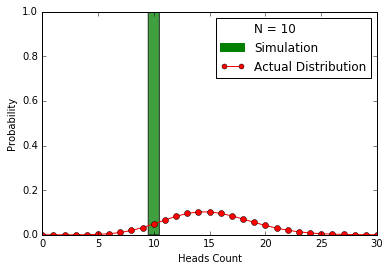

In [165]:
plotpoiss(10)

When N <= L, random variable takes all probability mass at X = L

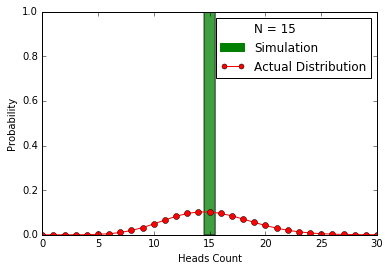

In [124]:
plotpoiss(15)

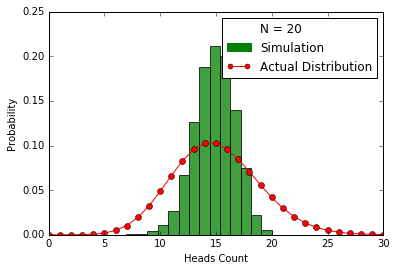

In [127]:
plotpoiss(20)

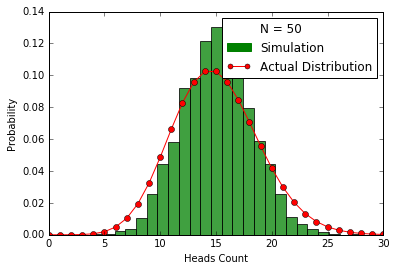

In [130]:
plotpoiss(50)

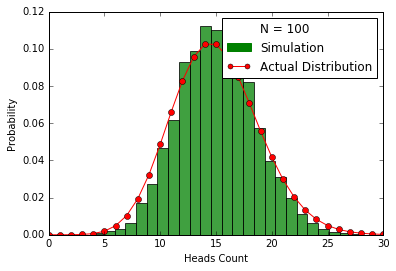

In [133]:
plotpoiss(100)

In [146]:
def l2norm(l,numheads):
    x = range(3*l)
    truevals = poisson.pmf(x,l,0)
    predvals = [numheads.count(i)/float(len(numheads)) for i in x]
    return sum([(i-j)**2 for i,j in zip (truevals,predvals)])**0.5

def linorm(l,numheads):
    x = range(3*l)
    truevals = poisson.pmf(x,l,0)
    predvals = [numheads.count(i)/float(len(numheads)) for i in x]
    return max([(i-j)**2 for i,j in zip (truevals,predvals)])**0.5


In [167]:
def errorplots(l,ns):

    l2errors = [l2norm(l,getheads(n,l,4000)) for n in ns]
    lierrors = [linorm(l,getheads(n,l,4000)) for n in ns]

    plt.plot(ns,l2errors)
    plt.plot(ns,lierrors)
    plt.xlabel('N')
    plt.ylabel('Error Value')
    plt.legend(['L2 Errors','L-inf Errors'])
    plt.show()

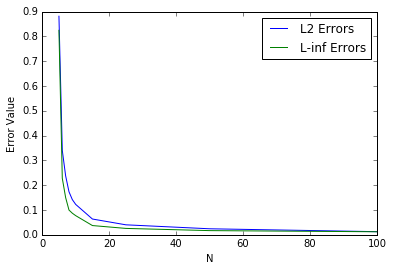

In [168]:
errorplots(5, [5,6,7,8,9,10,15,25,50,100] )

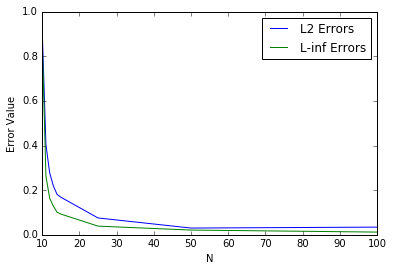

In [169]:
errorplots(10, range(10,15)+[15,25,50,100] )

### Q2 CLT

Gamma distribution

In [369]:
from scipy.stats import gamma
from scipy.stats import norm

from sklearn.neighbors import KernelDensity
import numpy as np

def gammaclt(n,a):
    Xbar = np.array([np.mean(gamma.rvs(a, size=n)) for i in range(500)])
    X_plot = np.linspace(0,5,100)

    mu = np.mean(Xbar)
    sigma = np.std(Xbar)
    YNorm = norm.pdf(X_plot,mu,sigma)

    kde = KernelDensity(kernel='epanechnikov',bandwidth=sigma/2).fit(Xbar.reshape(-1,1))
    scores = kde.score_samples(X_plot.reshape(-1,1))
    scores = np.exp(scores)

    plt.plot(X_plot,scores)
    plt.plot(X_plot,YNorm,linewidth=2,color='black')
    plt.xlabel('x')
    plt.ylabel('density')
    plt.legend(['Sample Average','True Gaussian'])
    plt.show()

def gaml2error(n,a):
    Xbar = np.array([np.mean(gamma.rvs(a, size=n)) for i in range(500)])
    X_plot = np.linspace(0,5,100)
    mu = np.mean(Xbar)
    sigma = np.std(Xbar)
    YNorm = norm.pdf(X_plot,mu,sigma)
    kde = KernelDensity(kernel='epanechnikov', bandwidth=sigma/2).fit(Xbar.reshape(-1,1))
    scores = kde.score_samples(X_plot.reshape(-1,1))
    scores = np.exp(scores)
    error = sum( (scores - YNorm) ** 2)**0.5
    return error

def gaml2errornorm(n,a):
    Xbar = np.array([np.mean(gamma.rvs(a, size=n)) for i in range(500)])
    X_plot = np.linspace(0,5,100)
    mu = np.mean(Xbar)
    sigma = np.std(Xbar)
    YNorm = norm.pdf(X_plot,mu,sigma)
    kde = KernelDensity(kernel='epanechnikov', bandwidth=sigma/2).fit(Xbar.reshape(-1,1))
    scores = kde.score_samples(X_plot.reshape(-1,1))
    scores = np.exp(scores)
    error = sum( [ i**2 for i in (scores - YNorm)/max(scores)]  )**0.5
    return error   

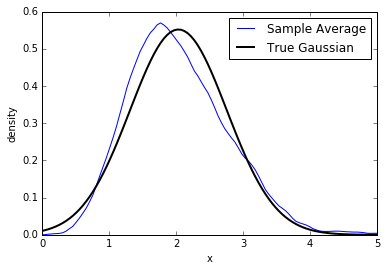

n = 2, a = 2


In [372]:
gammaclt(4,2)
print 'n = 2, a = 2'

#skews slightly

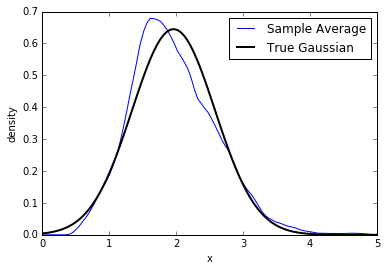

n = 5, a = 2


In [374]:
gammaclt(5,2)
print 'n = 5, a = 2'

#closer match

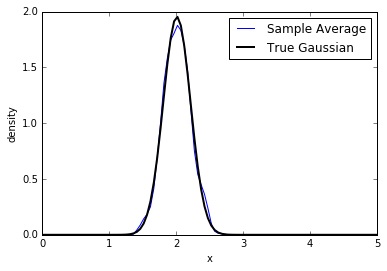

n = 50, a = 2


In [375]:
gammaclt(50,2)
print 'n = 50, a = 2'


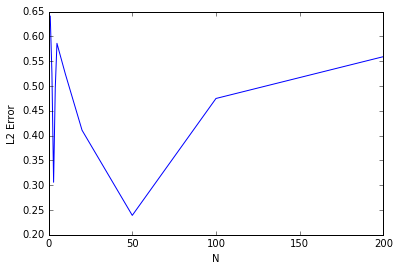

In [370]:
ns = [1,2,3,4,5,10,20,50,100,200]
errors = [gaml2error(n,2) for n in ns]

plt.plot(ns,errors)
plt.xlabel('N')
plt.ylabel('L2 Error')
plt.show()

Trend is unclear. It would be better to normalize the error by the maximum value in the distribution. The L2Norm penalizes larger errors much more, even if the shape is approximately correct.

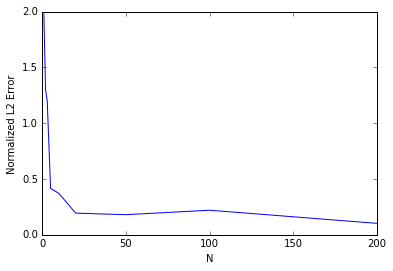

In [371]:
ns = [1,2,3,4,5,10,20,50,100,200]
errors = [gaml2errornorm(n,2) for n in ns]

plt.plot(ns,errors)
plt.xlabel('N')
plt.ylabel('Normalized L2 Error')
plt.show()

### Q3 AB Test

Let's say that the actual probability of an effect is p.

Power calculations:
https://en.wikipedia.org/wiki/G-test
http://www.real-statistics.com/chi-square-and-f-distributions/power-chi-square-tests/

In [136]:
import random
import math


p = 0.7 # probability of effect
ee = 0.1 #effect size if effect
uu1 = 0.15 #base conversion rate
N = 1000 #number of experiments/AB tests run
nn = 500 #number of samples per AB test

def flips(u1,u2,nn):
    control = [];
    test = [];
    for i in range(nn):
        if random.random()>0.5:
            control.append( 0 + (random.random() < u1) )
        else:
            test.append( 0 + (random.random() < u2) )
    return [control, test]

def trial(p,u1,e,nn):
    if random.random()>p:
        e = 0
    return flips(u1,u1+e,nn)+[e]

def outer(p,u1,e,nn):
    results = trial(p,u1,e,nn)
    control_count = len(results[0])
    control_success = sum(results[0])
    test_count = len(results[1])
    test_success = sum(results[1])
    is_effect = results[2]>0
    E = [0,0,0,0]
    O = [0,0,0,0]
    E[0]=(control_success + test_success)*control_count/float(nn)
    E[1]=control_count*(nn-control_success - test_success)/float(nn)
    E[2]=(control_success + test_success)*test_count/float(nn)
    E[3]=test_count*(nn-control_success - test_success)/float(nn)
    O[0]=control_success
    O[1]=control_count-control_success
    O[2]=test_success
    O[3]=test_count-test_success
    return [E,O,is_effect]

TP=0;FP=0;FN=0;TN=0;

for j in range(N):
    E,O,actual_effect = outer(p, uu1, ee, nn)
    G = 2*sum([oi*math.log(oi/ei) for oi,ei in zip(O,E)])
    #print G,
    if G>3.84: #G-value for alpha = 0.05
        if actual_effect:
            TP+=1
        else: 
            FP+=1
    else:
        if actual_effect:
            FN+=1
        else: 
            TN+=1
print

AE = [0,0,0,0]
AO = [0,0,0,0]
AE[0] = 0.5*nn*(uu1+ee/2)
AE[1] = 0.5*nn*(uu1+ee/2)
AE[2] = 0.5*nn*(1-uu1-ee/2)
AE[3] = 0.5*nn*(1-uu1-ee/2)
AO[0] = 0.5*nn*uu1
AO[1] = 0.5*nn*(uu1+ee)
AO[2] = 0.5*nn*(1-uu1)
AO[3] = 0.5*nn*(1-uu1-ee)

AltExpChisq = 2*sum([oi*math.log(oi/ei) for oi,ei in zip(AO,AE)])

from scipy.stats import ncx2
df = 1
nc = AltExpChisq

EstimatedBeta = ncx2.cdf(3.84, df, nc, loc=0, scale=1)
            
print 'True Pos =', TP
print 'Fals Pos =', FP
print 'True Neg =', TN
print 'Fals Neg =', FN
print 'Type I Error Rate =', FP/float(FP+TN)
print 'Type II Error Rate =', FN/float(FN+TP)
print 'Estimated p =', (TP+FP)/float(TP+FP+TN+FN)
print 'Calculated Power =', 1-EstimatedBeta


True Pos = 575
Fals Pos = 16
True Neg = 277
Fals Neg = 132
Type I Error Rate = 0.0546075085324
Type II Error Rate = 0.186704384724
Estimated p = 0.591
Calculated Power = 0.801669705102


In [65]:
(1-uu1)*math.log((1-uu1)/(1-uu1-ee/2))
(1-uu1-ee)*math.log((1-uu1-ee)/(1-uu1+ee/2))

-0.05799950148415808

In [2]:
import math

math.log(3)

1.0986122886681098

### Q4 HHT vs HTT

https://www.math.ucdavis.edu/~gravner/MAT135B/materials/pat.pdf

### Q5 Chip companies

For company A: $p(defective|A) = 20\%$

For company B: $p(defective|B) = 80\%$

So what is $P(A|\textrm{not defective})$?

$P(A|\textrm{not defective}) = \dfrac{p(\textrm{not defective}|A) * p(A) }{p(\textrm{not defective})}$

$p(\textrm{not defective}|A) = 1 - 20\% = 80\%$

$p(A) = 50\%$ (assuming no prior information, treat both outcomes equally).

$p(\textrm{not defective}) = 0.5*0.2+ 0.5*0.8 = 0.5$

$P(A|\textrm{not defective}) = 0.8*0.5 / 0.5 = 0.8$

### Now what is the probability of the next chip being not defective?

We have a new prior for P(A) = 0.80 so:

$p(\textrm{not defective}|A)*P(A) + p(\textrm{not defective}|B)*P(B) = 0.8*0.8 + 0.2*0.2 = 0.68$

### Q6 Expected Number of Draws

Start with a set $S = \{1,2,3,4, ... ,n\}$

Pick an element $x \in S$ so that $x \neq 1$.

With replacement:

Each subsequent draw reduces to a binomial trial.

The probability of success $p = \dfrac{x-1}{n}$ since there are $x-1$ possible picks less than $x$ out of $n$ total. 

Now, the number of trials until <strong>failure</strong> is in fact a negative binomial distributed random variable.

Due to the definition of negative binomial, we have to redefine our p, such that it is one minus the previous p:

$p = 1-\dfrac{x-1}{n} = \dfrac{n-x+1}{n} $

Negative binomial distribution is the number of binomial trials until some number of failures. The expectation or mean value of the negative binomial is:

$E[NB] = \dfrac{p*r}{1-p} $ 

Where $r$ is the number of failures awaited (1), and p is the probability of success (in our case, for the purposes of the negative binomial, success is the draw is greater than or equals x, failure is that it is less than x, we wait for one failure).

$E[NB] = \dfrac{p*r}{1-p} = \dfrac{\tfrac{n-x+1}{n}}{1-\tfrac{n-x+1}{n}} = \dfrac{n-x+1}{x-1}$

Without replacement:

Similar, but it is now negative hypergeometric distribution instead of negative binomial.

Negative hypergeometric is defined with mean:

$E[NHG] = R\dfrac{K}{N-K+1}$ where $R$ is the number of failures awaited, $N$ is the number of samples, with $K$ successes. Again, we will 'reverse' the definition of success to accomodate the definition of negative hypergeometric. So values >= x are successes, and < x are failures. Thus there are x-1 failures and n-x successes (1 has already been drawn) $K = n-x, N=n-1, R=1$

$E[NHG] = \dfrac{n-x}{n-1-(n-x)+1} = \dfrac{n-x}{x} $


### Q7 Packets



In [43]:
import matplotlib.pyplot as plt
from scipy.stats import poisson

### assume packets arrive as a poisson process

ax = plt.subplot()
x = range(10) ###probability drops off quickly
y = [poisson.pmf(xi,0.693147,0) for xi in x] ### iterate to find value such that P(x>0 = 0.5)
print y
yquarter = [poisson.pmf(xi,0.693147/4,0) for xi in x] ### 1/4 exposure reduces poisson parameter by four-fold
prob = sum(yquarter[1:])
print 'probability =', '{:.3g}% '.format(prob*100)

[0.50000009027998082, 0.34657356257729782, 0.12011321258988314, 0.02775203765567991, 0.0048090604112303913, 0.00066667715937262259, 7.7017545497942523e-05, 7.6263543727517684e-06, 6.6077308180122018e-07, 5.0890319925696778e-08]
probability = 15.9% 
